In [44]:
import pickle
X_acl,X_ppg,y,y_participant = pickle.load(open('../data/tabular_data.p','rb'))

In [45]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [46]:
for k in range(X_ppg.shape[0]):
    X_ppg[k] = MinMaxScaler().fit_transform(X_ppg[k])

In [47]:
import numpy as np
X_ppg = X_ppg[:,np.arange(0,512,2),:]

In [48]:
X_acl = np.concatenate([X_ppg,X_acl],axis=-1)

In [49]:
y = X_ppg[:,:,0].reshape(-1,256,1)
X_acl = X_acl[:,:,:1]

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from keras.layers import *
from keras.models import *
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input
from keras.models import Model, Sequential

In [51]:
logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X_acl, y, y_participant.reshape(-1)):
    train_x, test_x = X_acl[train_index], X_acl[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_participant, test_participant = y_participant[train_index], y_participant[test_index]
    break


train_x, val_x, train_y, val_y,train_participant,val_participant = train_test_split(train_x, 
                                                                                    train_y,
                                                                                    train_participant,
                                                                                    test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape),(test_x.shape,test_y.shape)

(((36675, 256, 1), (36675, 256, 1)),
 ((4076, 256, 1), (4076, 256, 1)),
 ((2612, 256, 1), (2612, 256, 1)))

In [58]:
def get_model(input_shape=(256,1),act='tanh',loss="mae",opt='adam',n_classes=1):
    model =  Sequential()
    model.add(Conv1D(100,10,input_shape=input_shape,activation='tanh',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(5))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(50,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Reshape((10,2)))
    model.add(Conv1D(100,2,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(256,2,input_shape=input_shape,activation='tanh',kernel_initializer='normal',padding='same'))
    model.add(Reshape((256,10)))
    model.add(TimeDistributed(Dense(1,activation='sigmoid')))
#     model.add(Dense(64,activation='relu'))
#     model.add(Dense(128,activation='tanh'))
#     model.add(Dense(256,activation='sigmoid'))
#     model.add(Reshape((256,1)))
    
    
#     model.add(Bidirectional(LSTM(100,return_sequences=True,activation='tanh',kernel_initializer='normal')))
#     model.add(TimeDistributed(Dense(1,activation='')))
    model.compile(loss=loss,optimizer=opt)
    return model

In [59]:
model = get_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 256, 100)          1100      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 128, 100)          0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 100)          400       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 100)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 128, 100)          200100    
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 25, 100)           0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 25, 100)          

In [60]:
from keras.models import load_model
filepath = '../model_files/CNN_plus_LSTM.hdf5'
# model = load_model(filepath)

In [61]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=100, batch_size=200,
          callbacks=callbacks_list,shuffle=True)

Train on 36675 samples, validate on 4076 samples
Epoch 1/100
36675/36675 [==============================] - 14s 370us/step - loss: 0.1305 - val_loss: 0.1745

Epoch 00001: val_loss improved from inf to 0.17453, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 2/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0990 - val_loss: 0.1592

Epoch 00002: val_loss improved from 0.17453 to 0.15923, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 3/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0911 - val_loss: 0.1145

Epoch 00003: val_loss improved from 0.15923 to 0.11453, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 4/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0876 - val_loss: 0.0849

Epoch 00004: val_loss improved from 0.11453 to 0.08488, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 5/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0838 - val_

36675/36675 [==============================] - 13s 353us/step - loss: 0.0720 - val_loss: 0.0692

Epoch 00044: val_loss did not improve from 0.06849
Epoch 45/100
36675/36675 [==============================] - 13s 354us/step - loss: 0.0719 - val_loss: 0.0679

Epoch 00045: val_loss improved from 0.06849 to 0.06786, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 46/100
36675/36675 [==============================] - 13s 354us/step - loss: 0.0718 - val_loss: 0.0690

Epoch 00046: val_loss did not improve from 0.06786
Epoch 47/100
36675/36675 [==============================] - 13s 355us/step - loss: 0.0719 - val_loss: 0.0680

Epoch 00047: val_loss did not improve from 0.06786
Epoch 48/100
36675/36675 [==============================] - 13s 354us/step - loss: 0.0718 - val_loss: 0.0713

Epoch 00048: val_loss did not improve from 0.06786
Epoch 49/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0717 - val_loss: 0.0698

Epoch 00049: val_loss did not improve from 


Epoch 00093: val_loss did not improve from 0.06656
Epoch 94/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0706 - val_loss: 0.0669

Epoch 00094: val_loss did not improve from 0.06656
Epoch 95/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0707 - val_loss: 0.0665

Epoch 00095: val_loss improved from 0.06656 to 0.06653, saving model to ../model_files/CNN_plus_LSTM.hdf5
Epoch 96/100
36675/36675 [==============================] - 13s 355us/step - loss: 0.0707 - val_loss: 0.0667

Epoch 00096: val_loss did not improve from 0.06653
Epoch 97/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0706 - val_loss: 0.0672

Epoch 00097: val_loss did not improve from 0.06653
Epoch 98/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.0706 - val_loss: 0.0670

Epoch 00098: val_loss did not improve from 0.06653
Epoch 99/100
36675/36675 [==============================] - 13s 353us/step - loss: 0.070

In [62]:
filepath = '../model_files/CNN_plus_LSTM.hdf5'
model = load_model(filepath)

In [63]:
test_y_pred = model.predict(test_x)

<IPython.core.display.Javascript object>


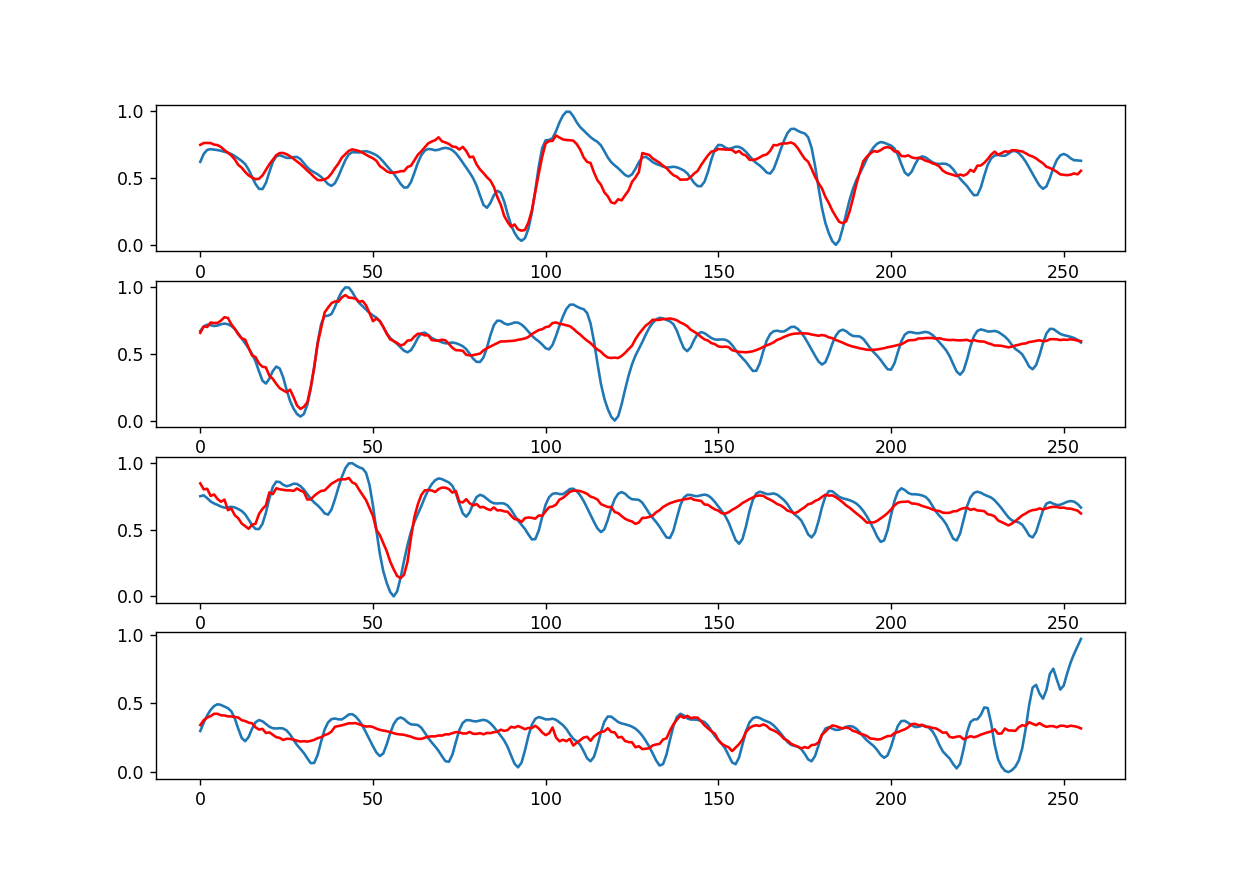

<IPython.core.display.Javascript object>


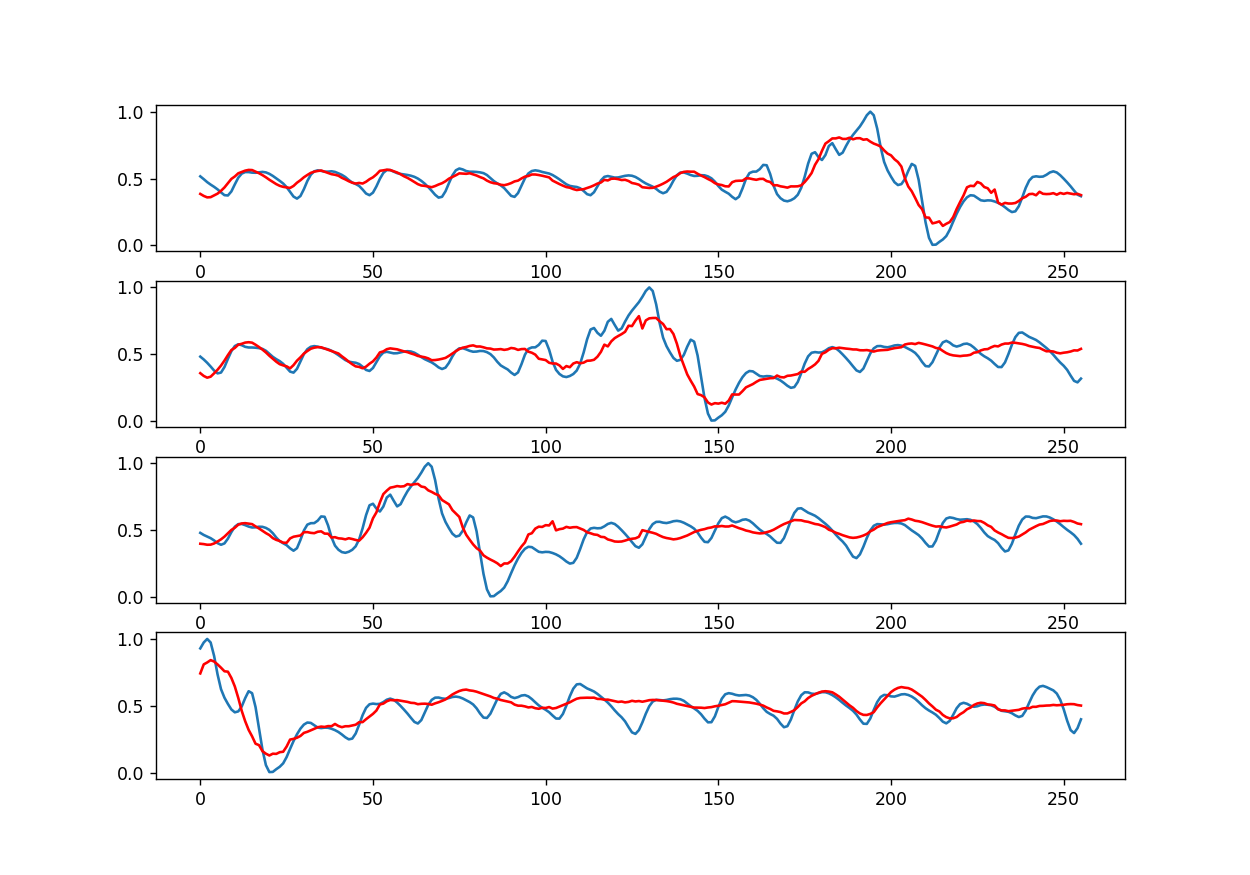

<IPython.core.display.Javascript object>


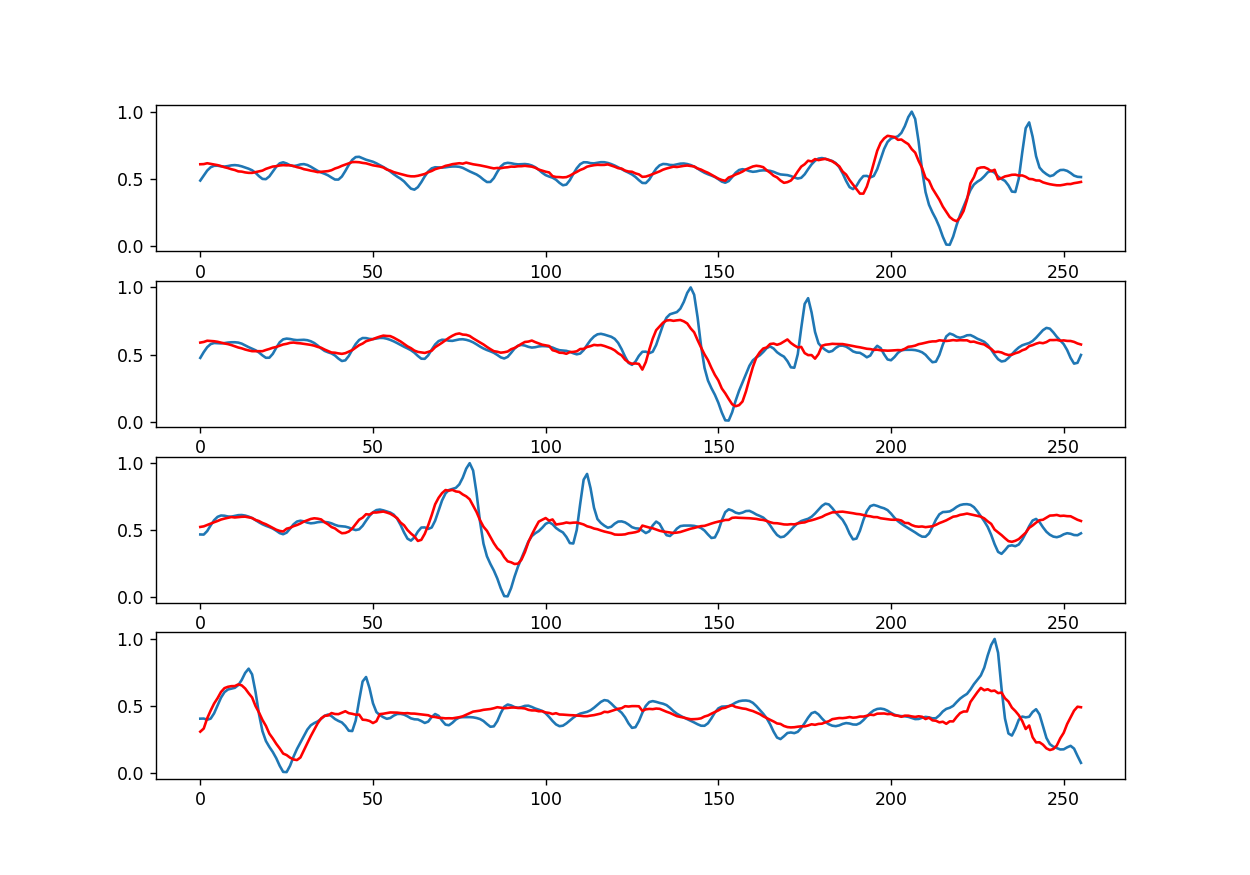

<IPython.core.display.Javascript object>


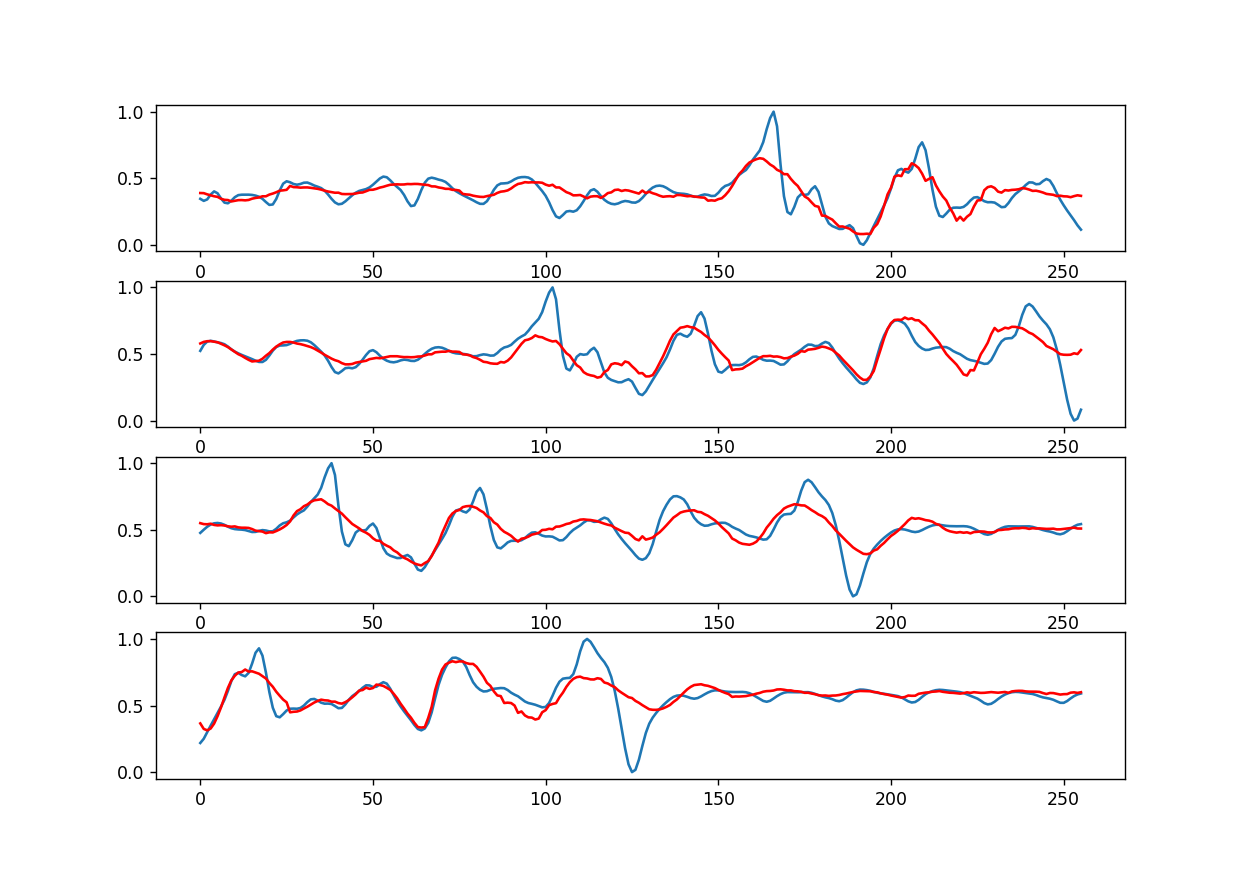

<IPython.core.display.Javascript object>


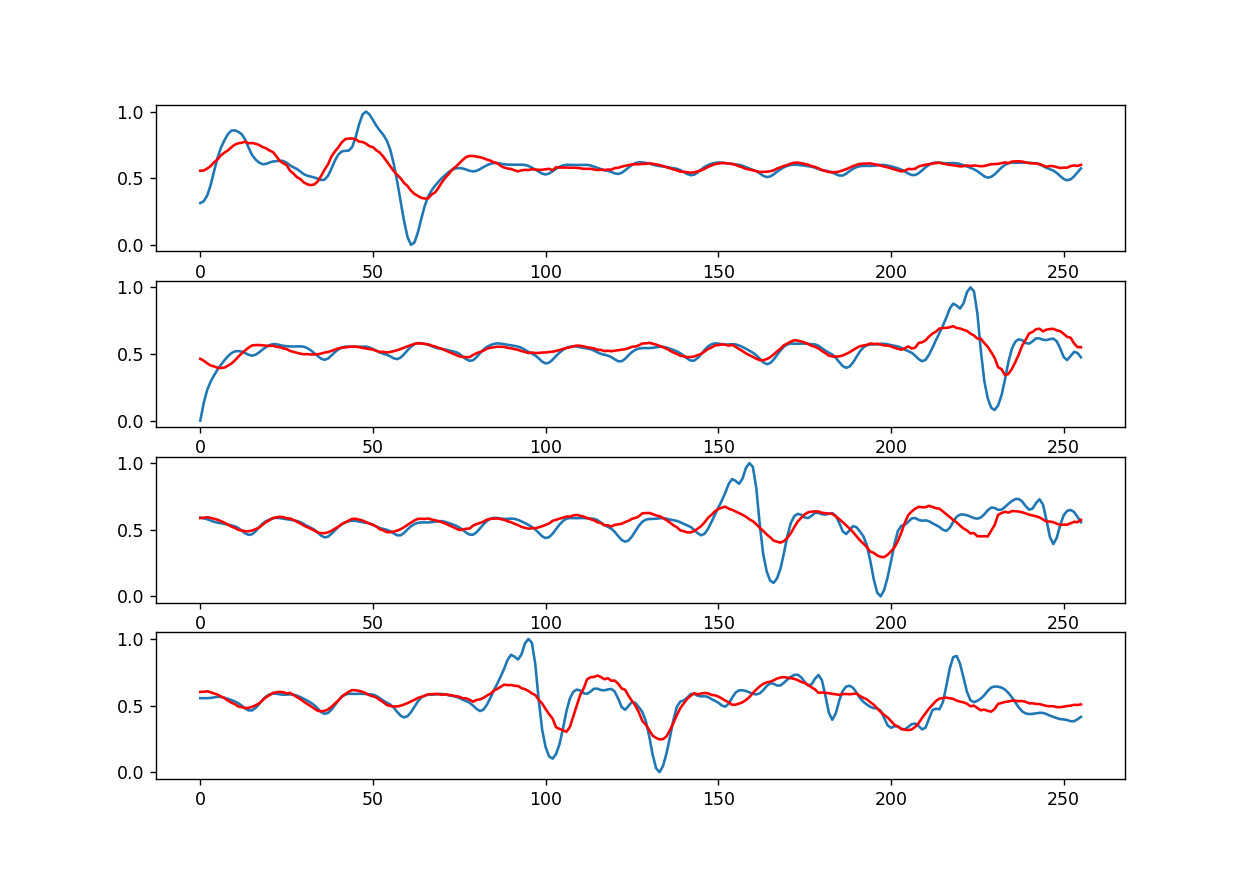

<IPython.core.display.Javascript object>


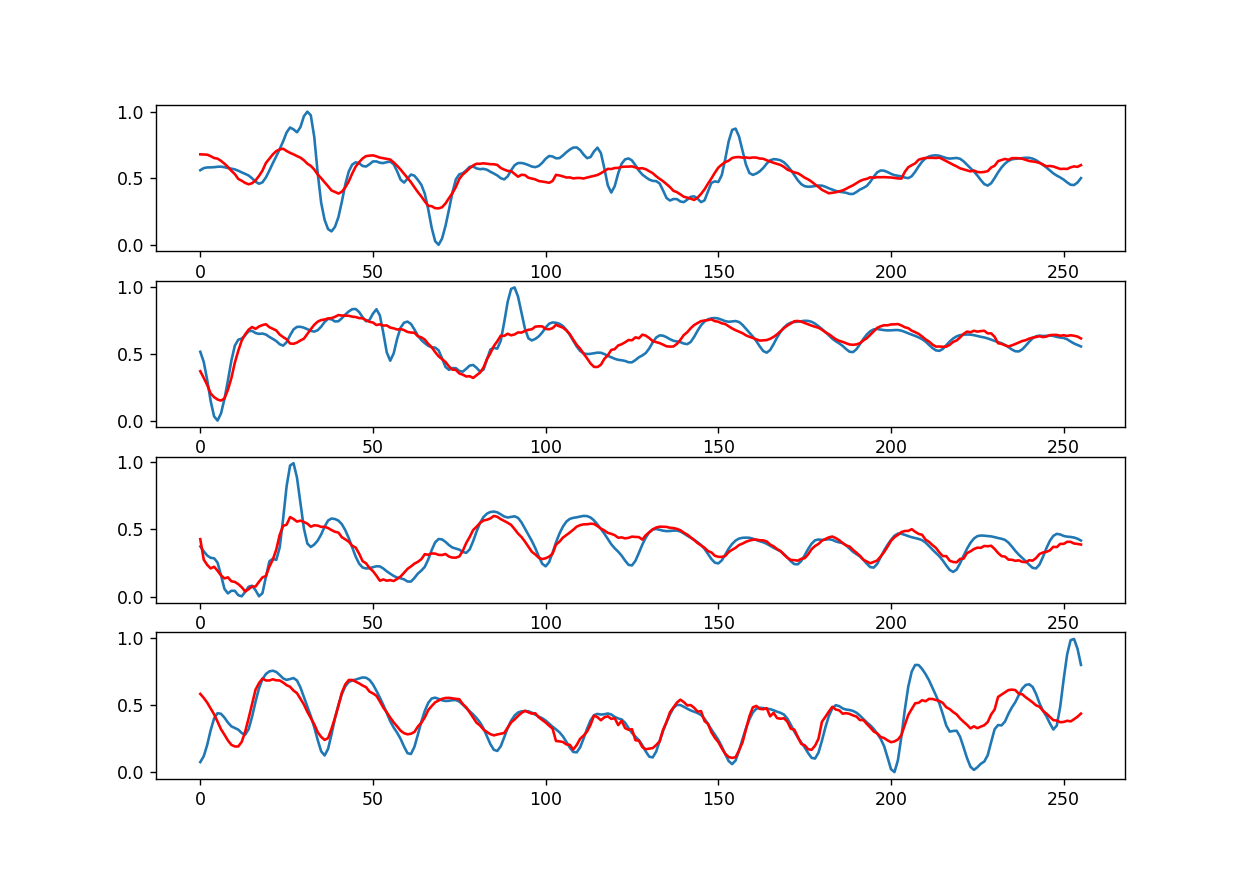

<IPython.core.display.Javascript object>


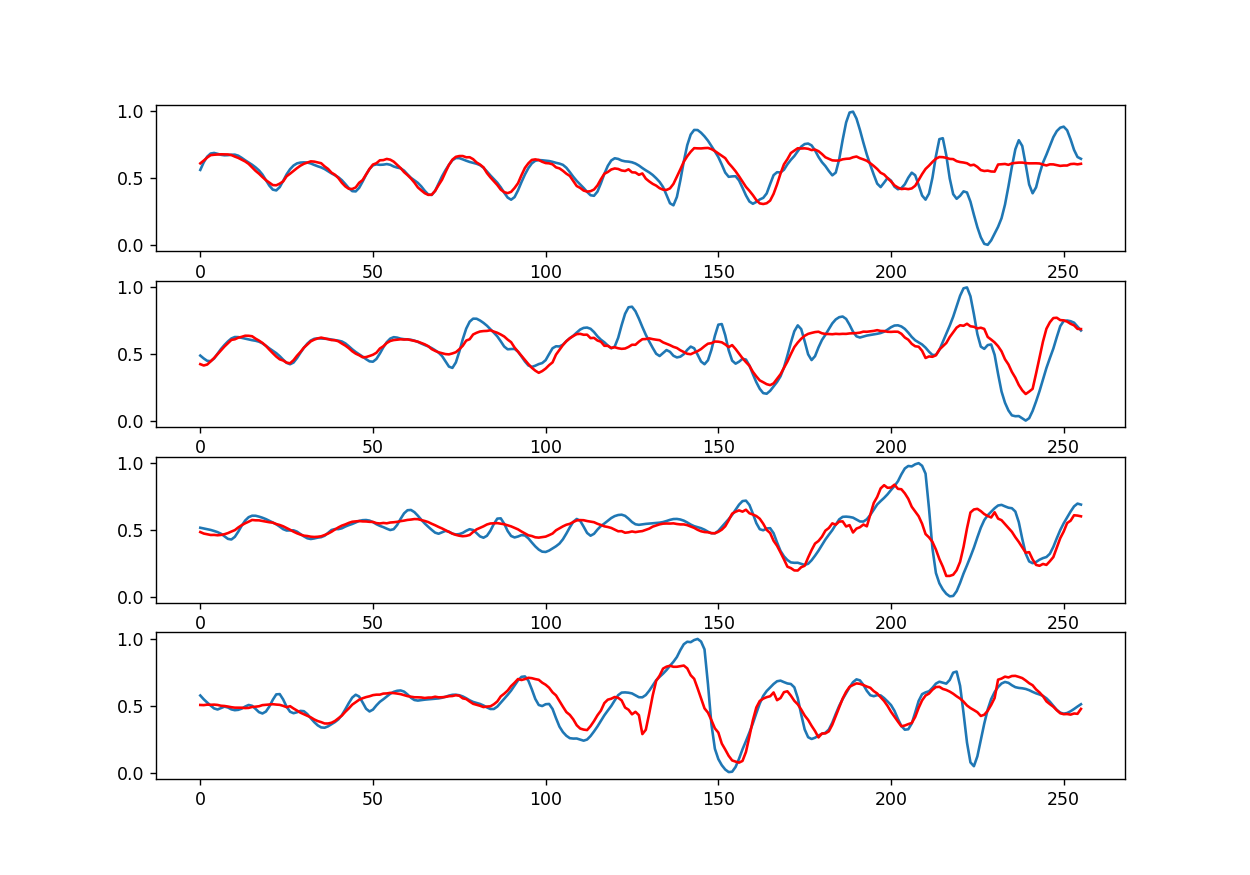

<IPython.core.display.Javascript object>


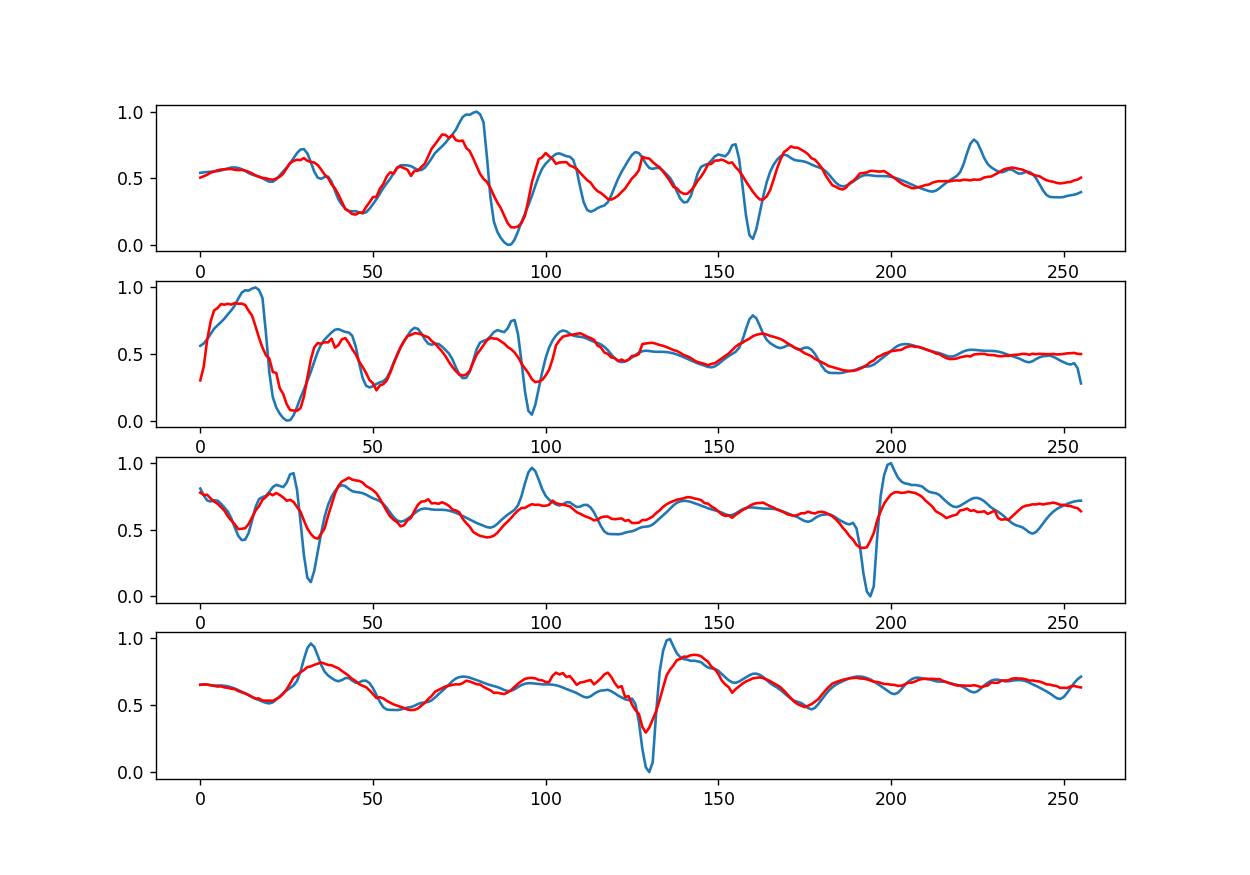

<IPython.core.display.Javascript object>


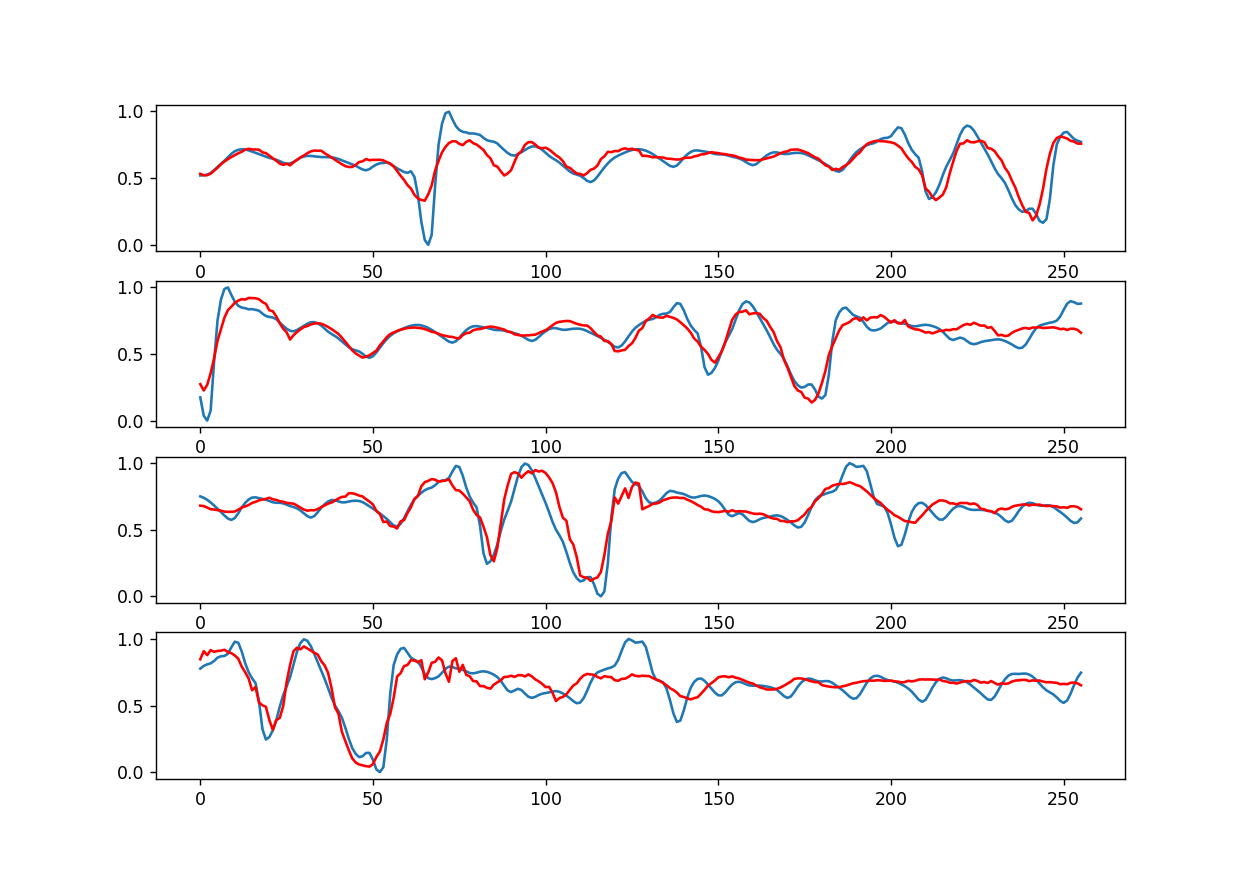

<IPython.core.display.Javascript object>


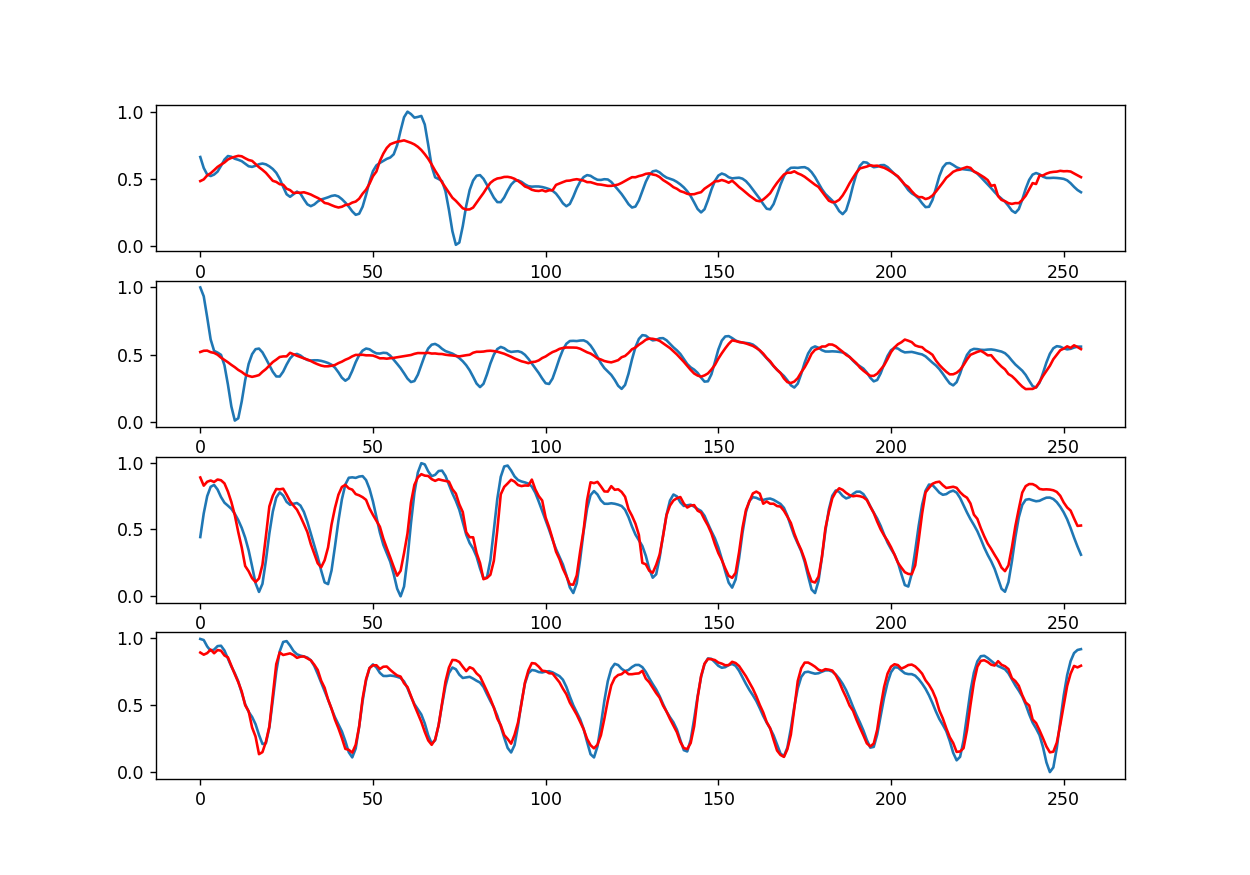

<IPython.core.display.Javascript object>


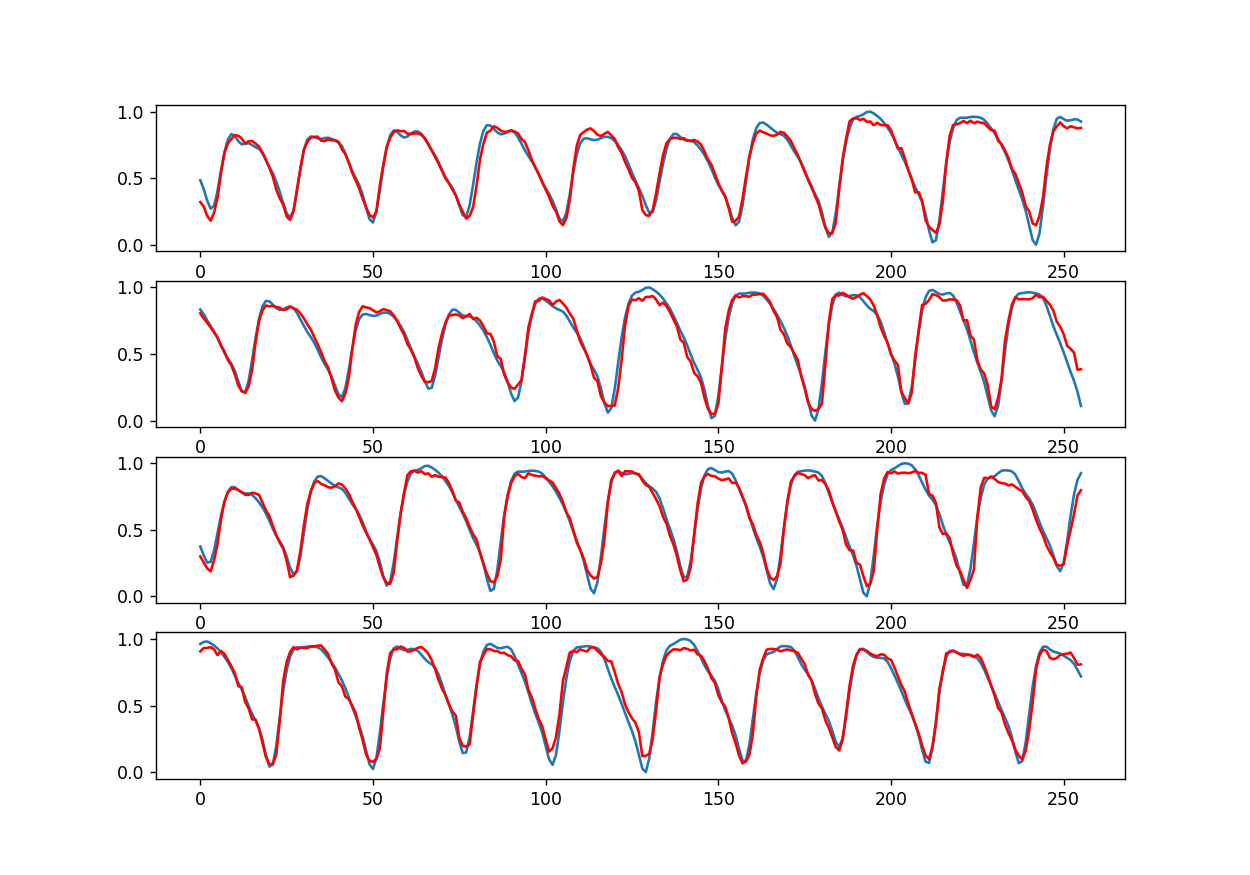

<IPython.core.display.Javascript object>


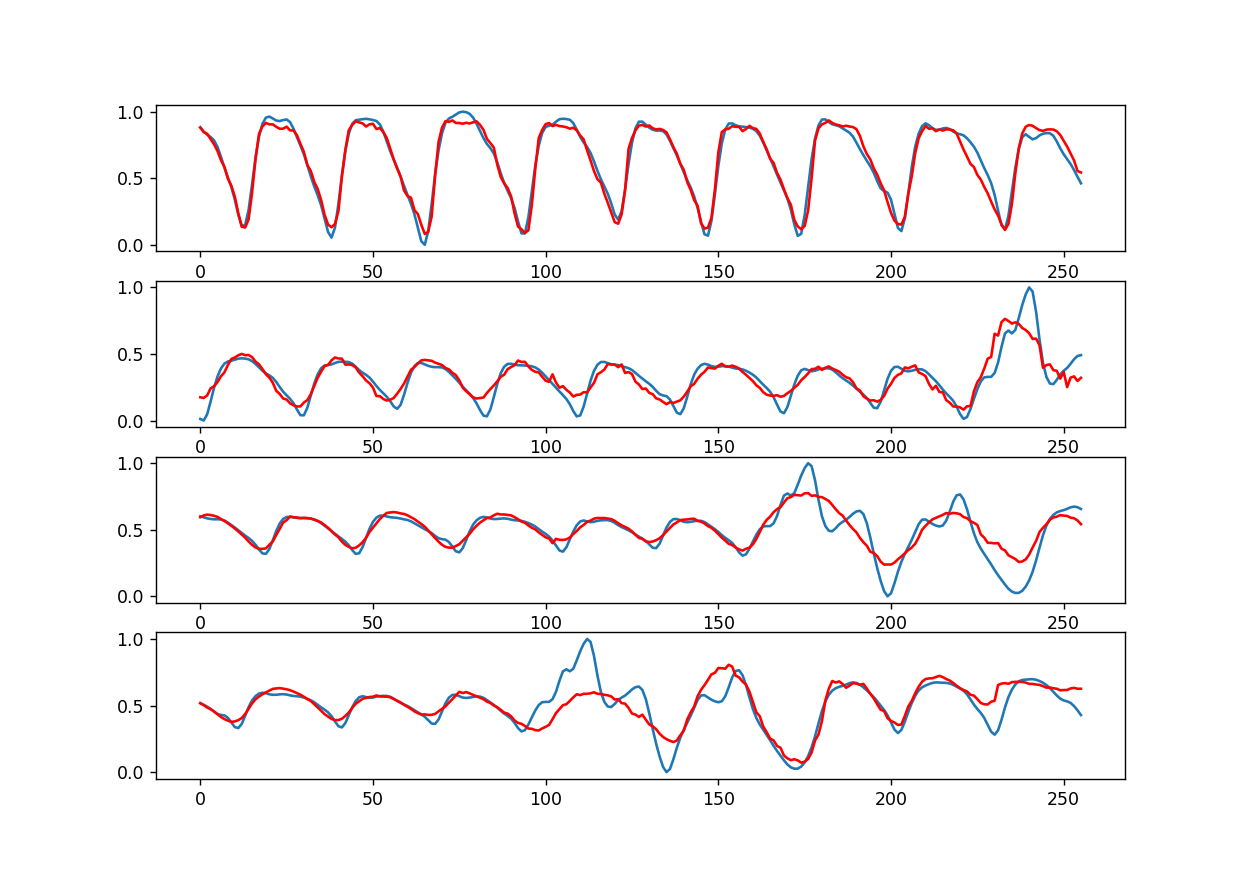

<IPython.core.display.Javascript object>


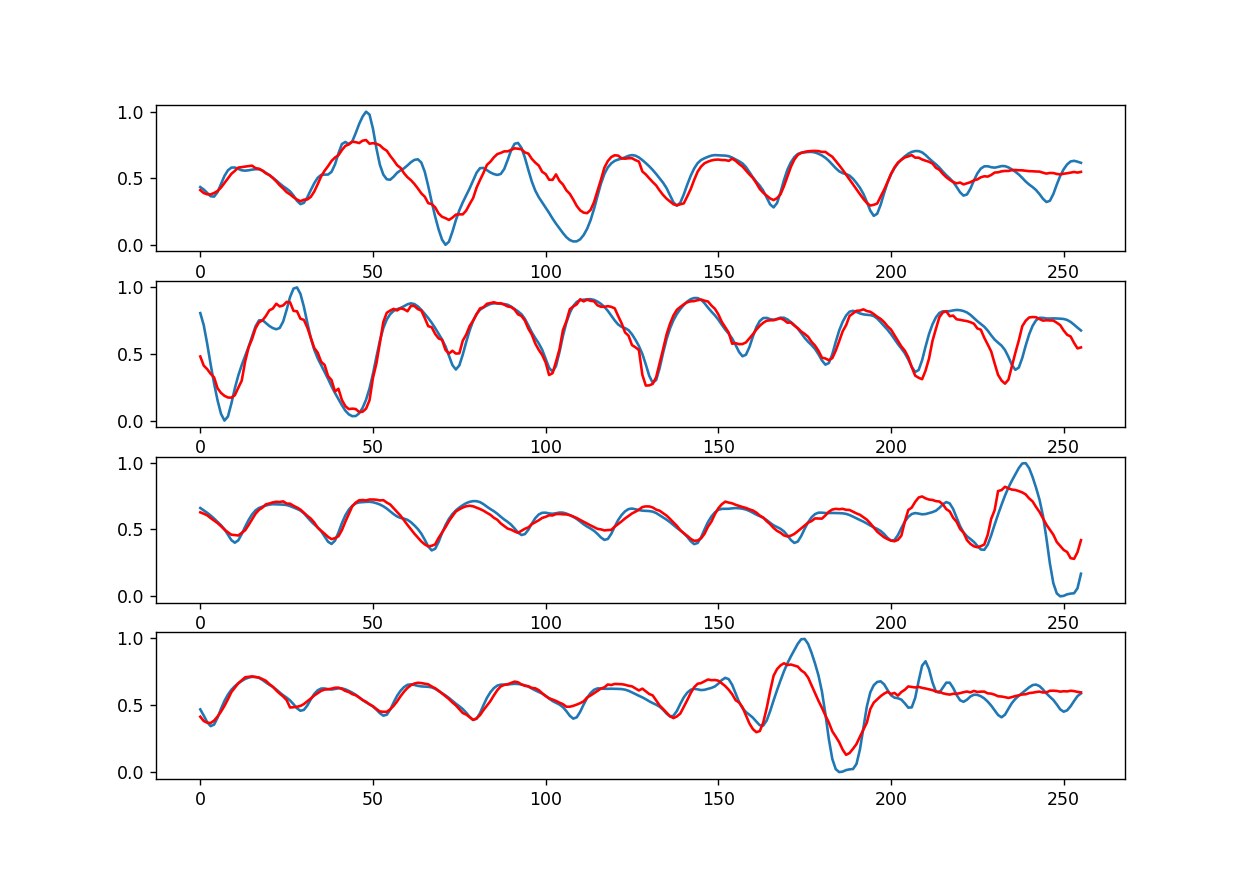

<IPython.core.display.Javascript object>


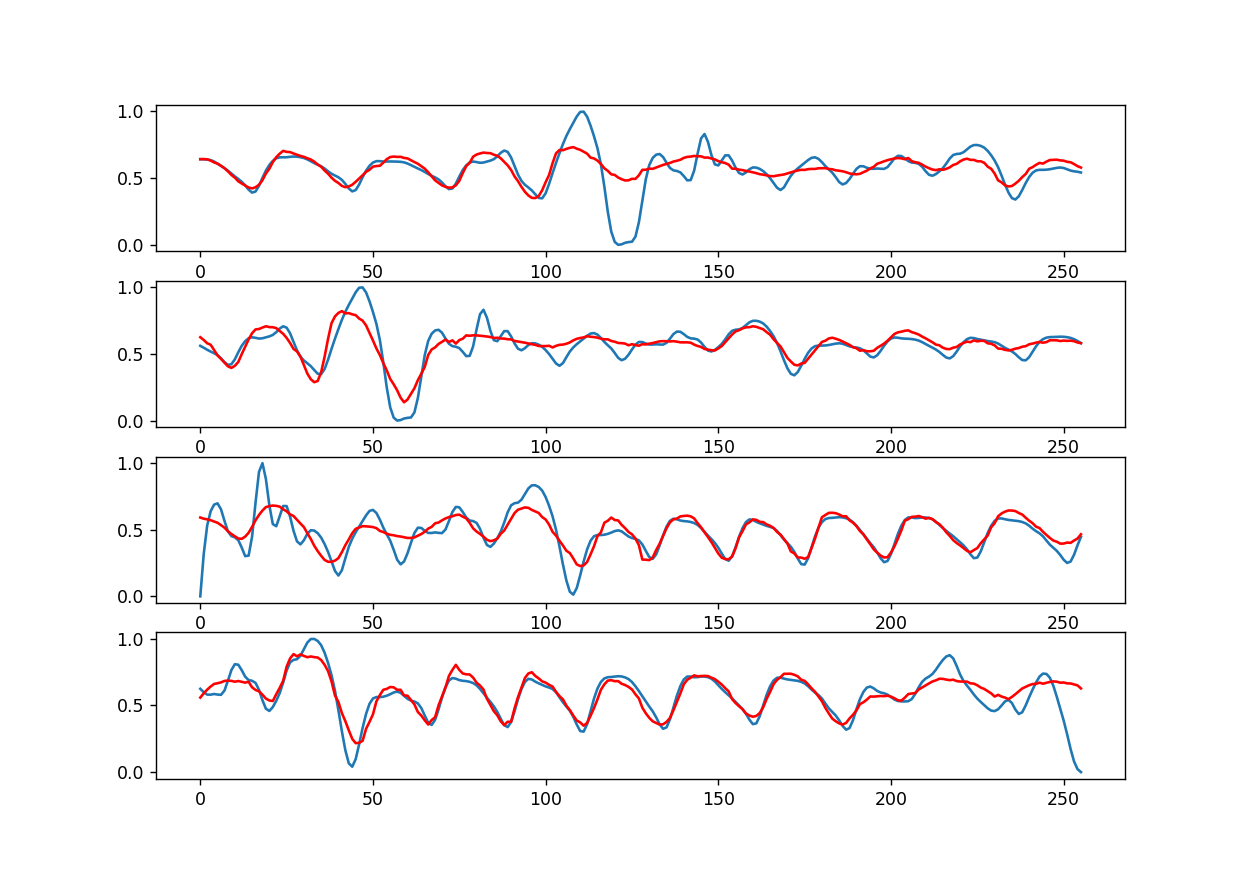

<IPython.core.display.Javascript object>


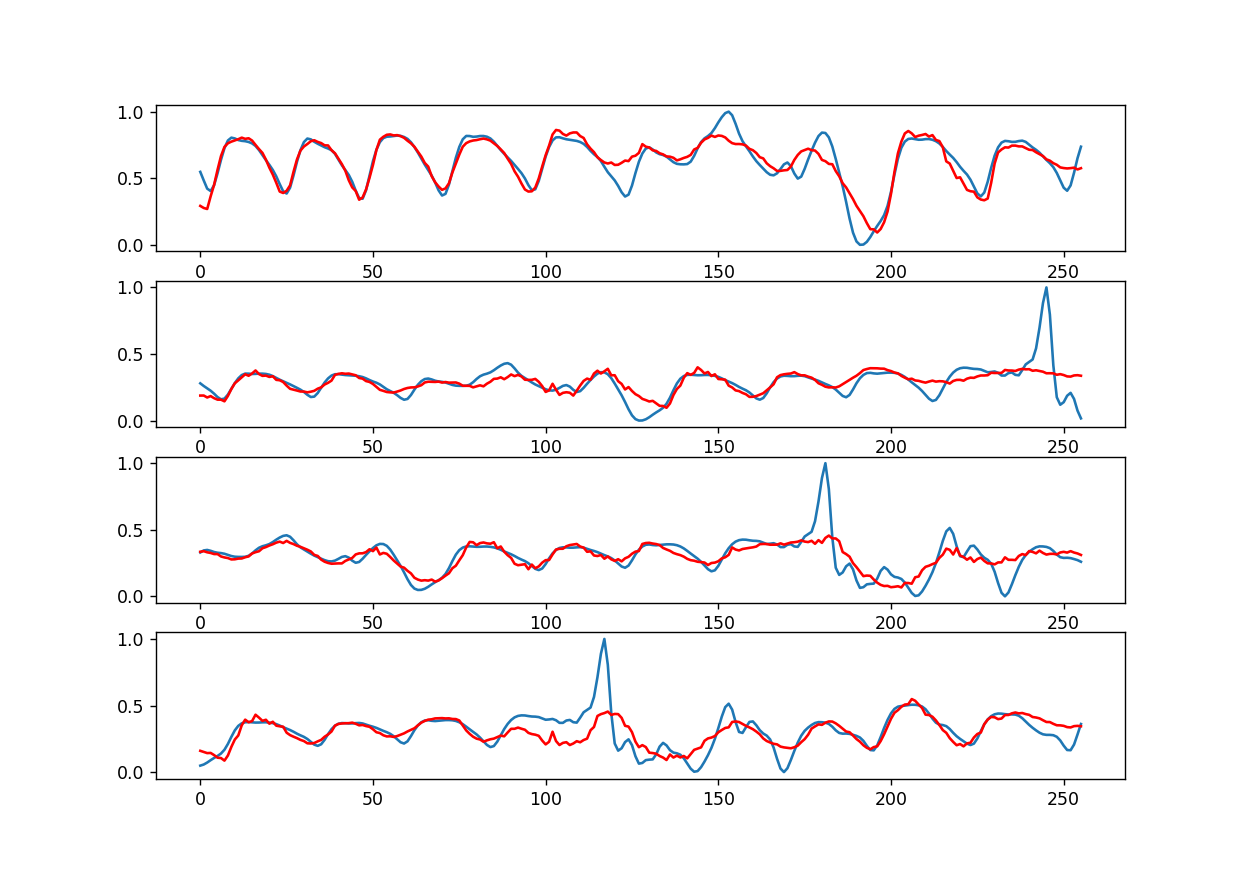

<IPython.core.display.Javascript object>


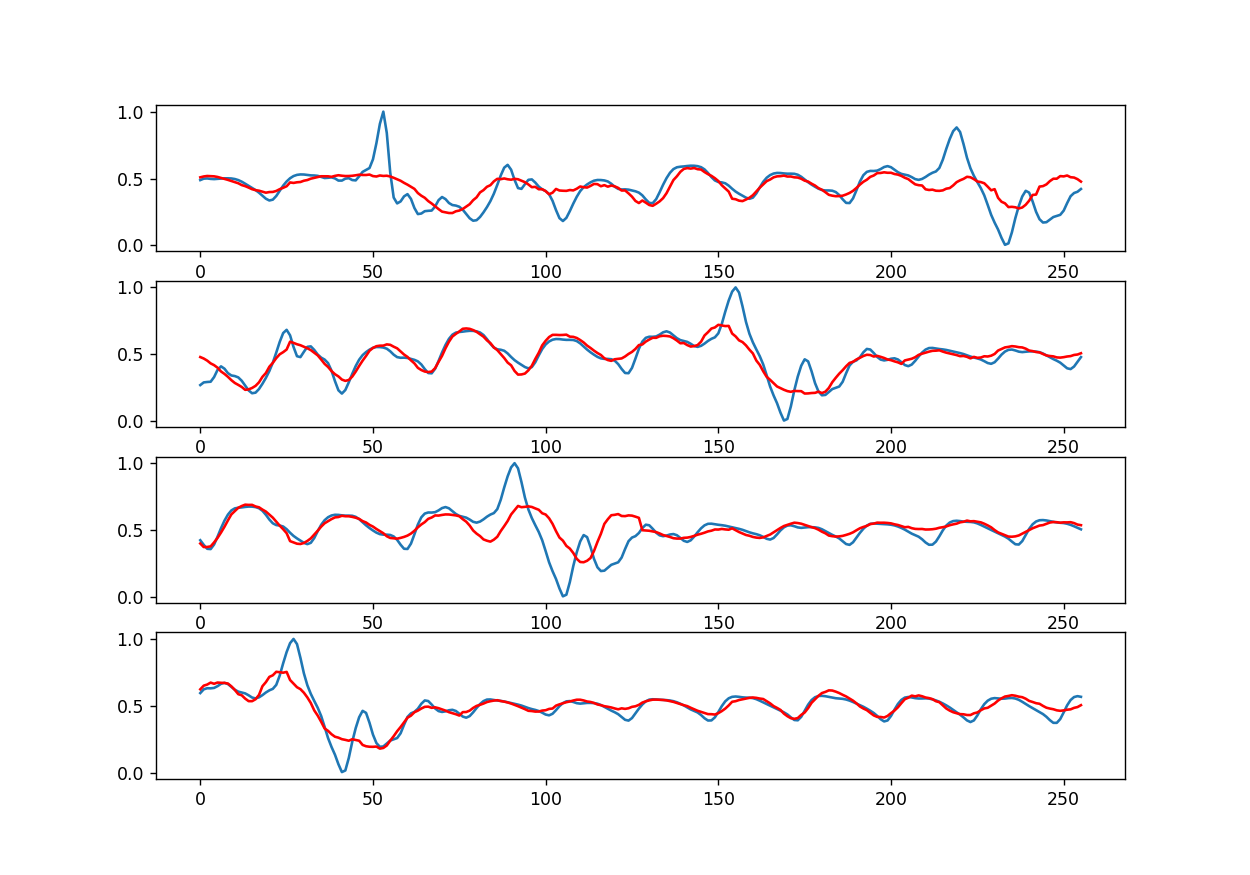

<IPython.core.display.Javascript object>


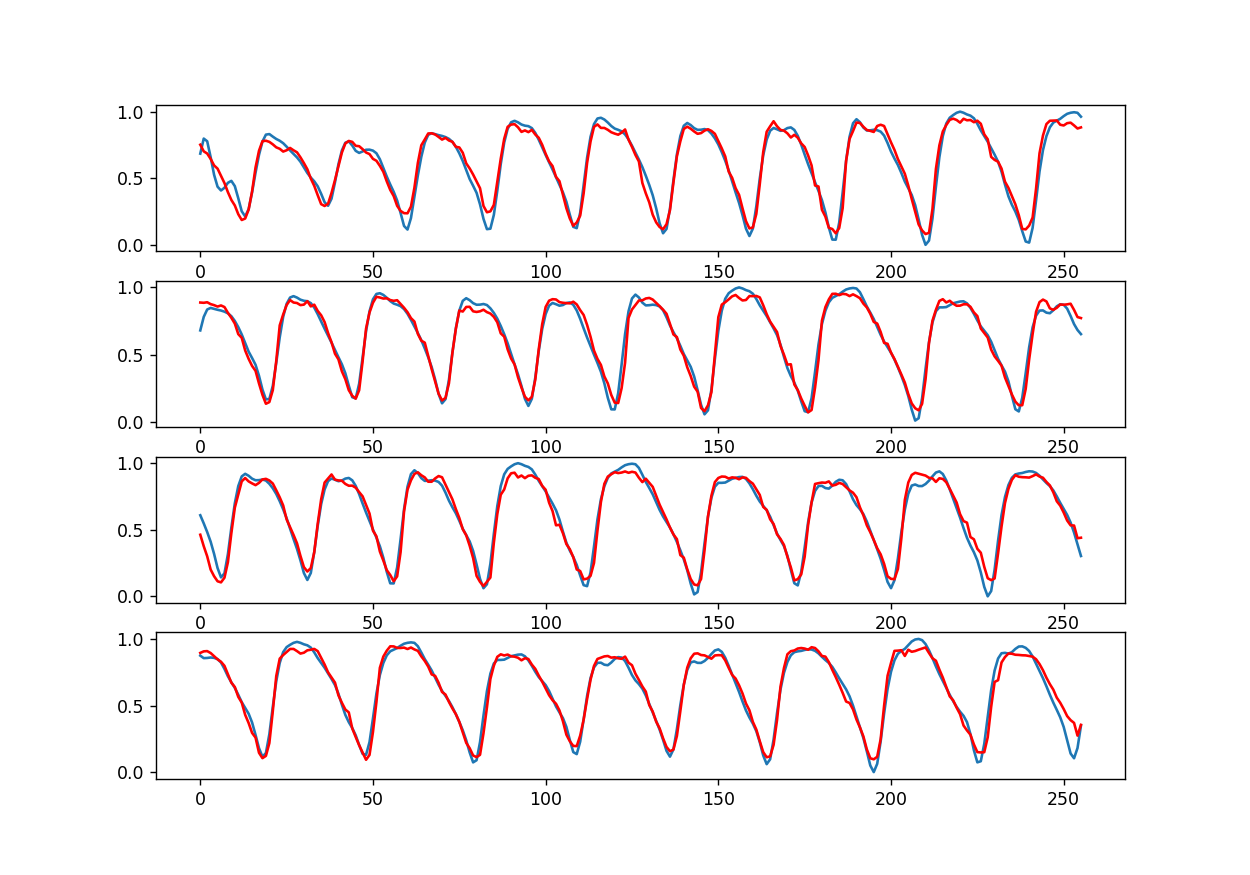

<IPython.core.display.Javascript object>


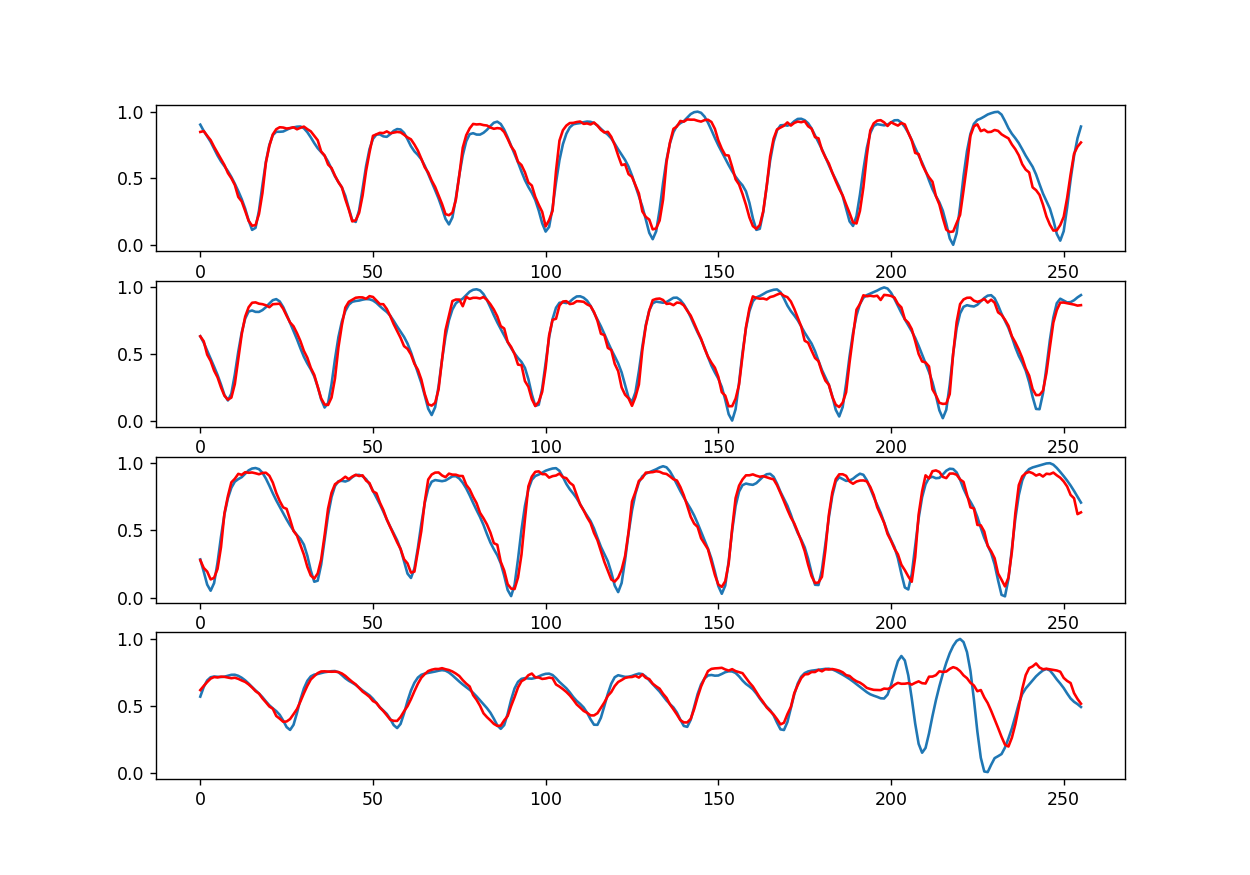

<IPython.core.display.Javascript object>


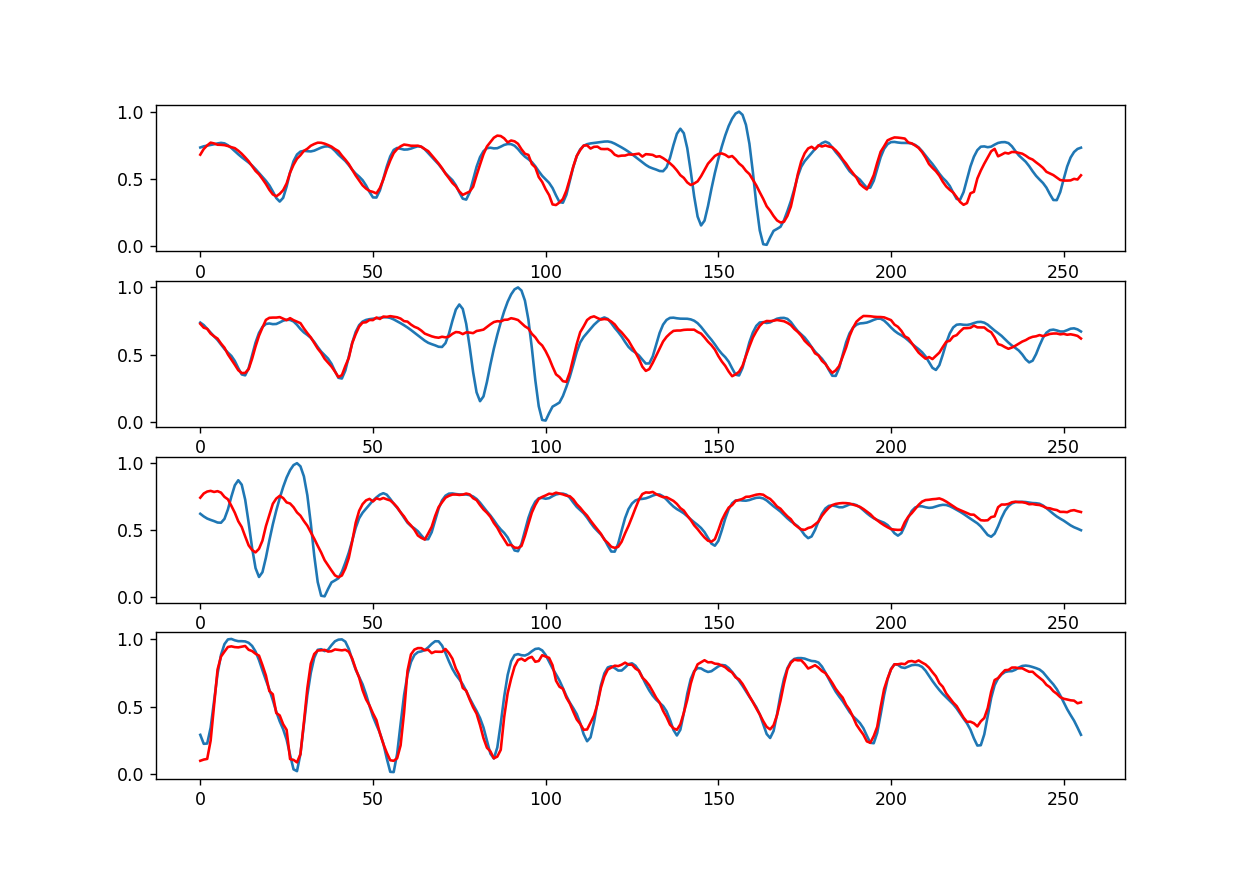

<IPython.core.display.Javascript object>


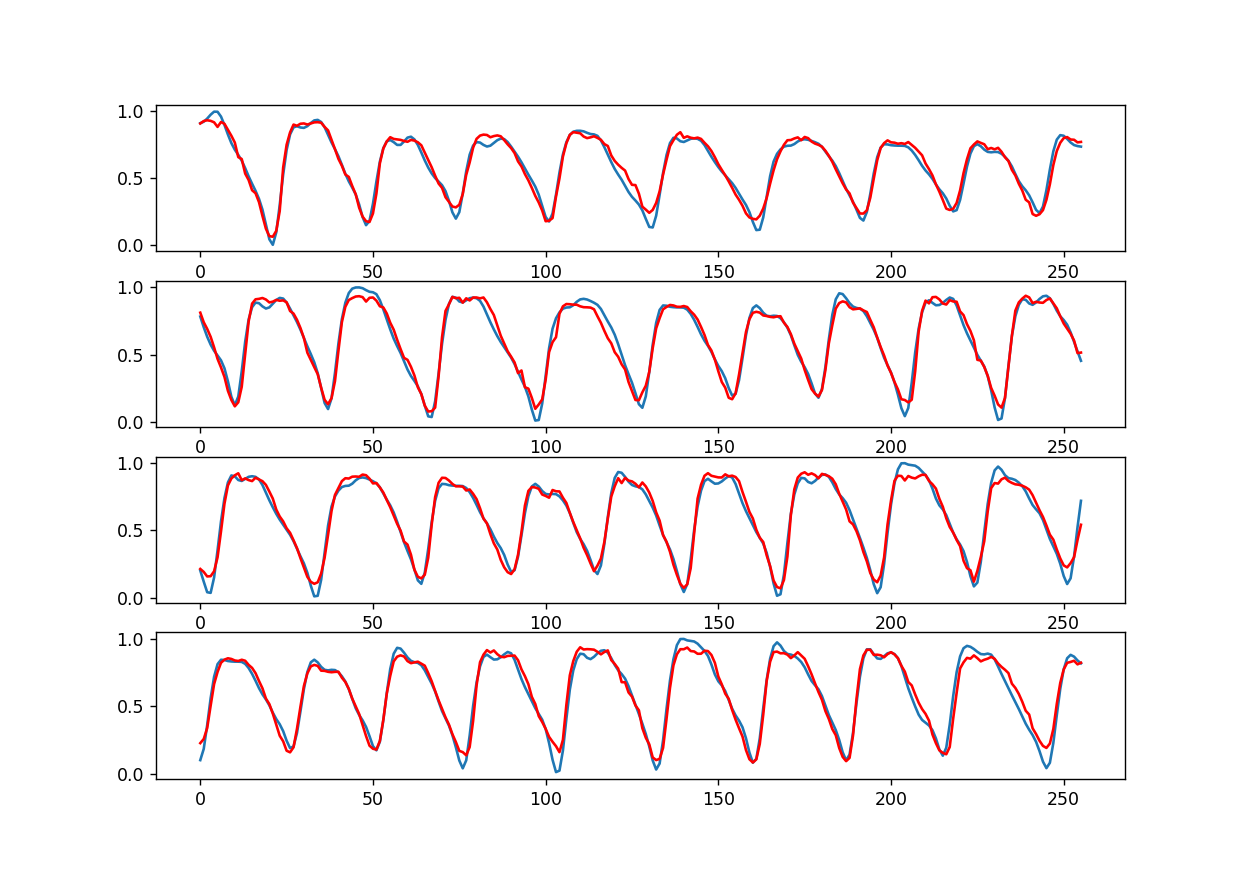

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


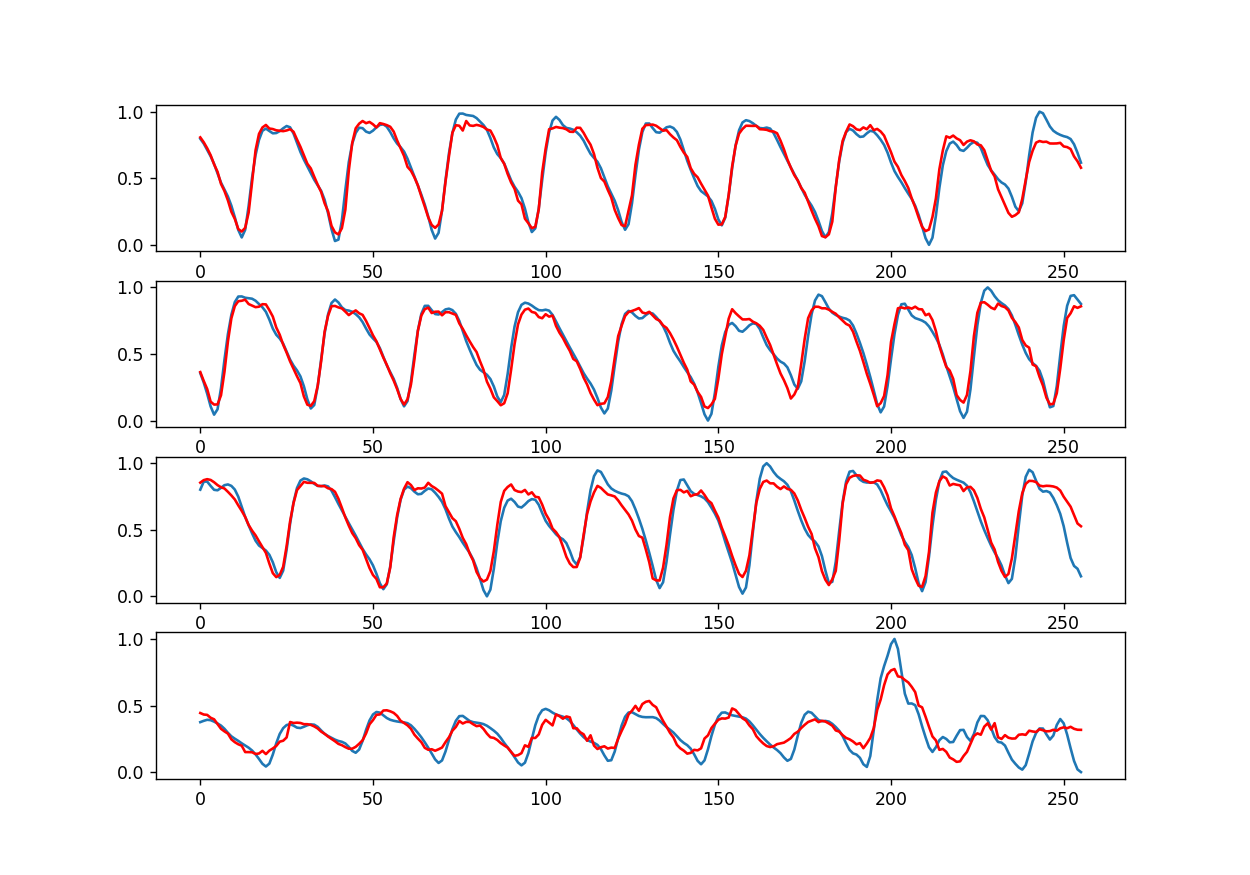

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


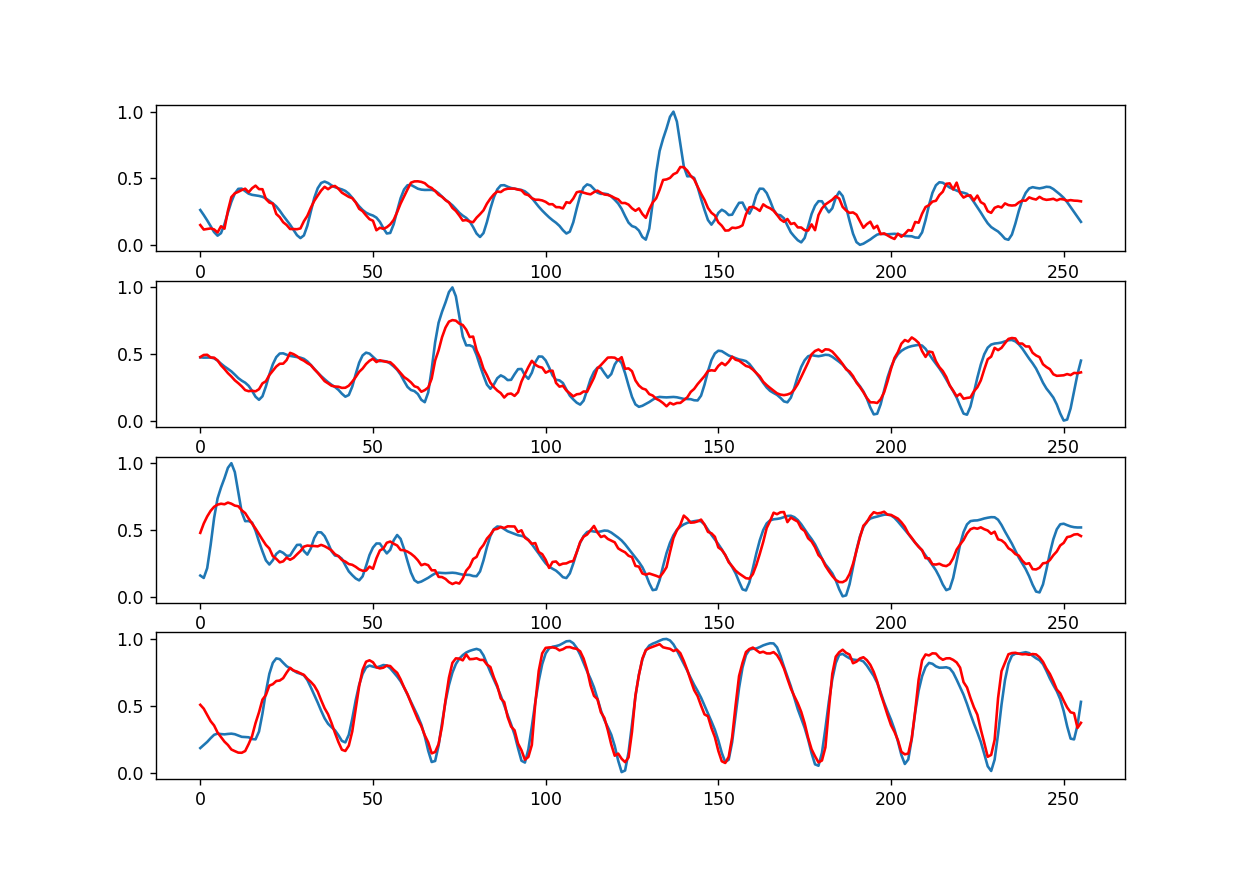

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


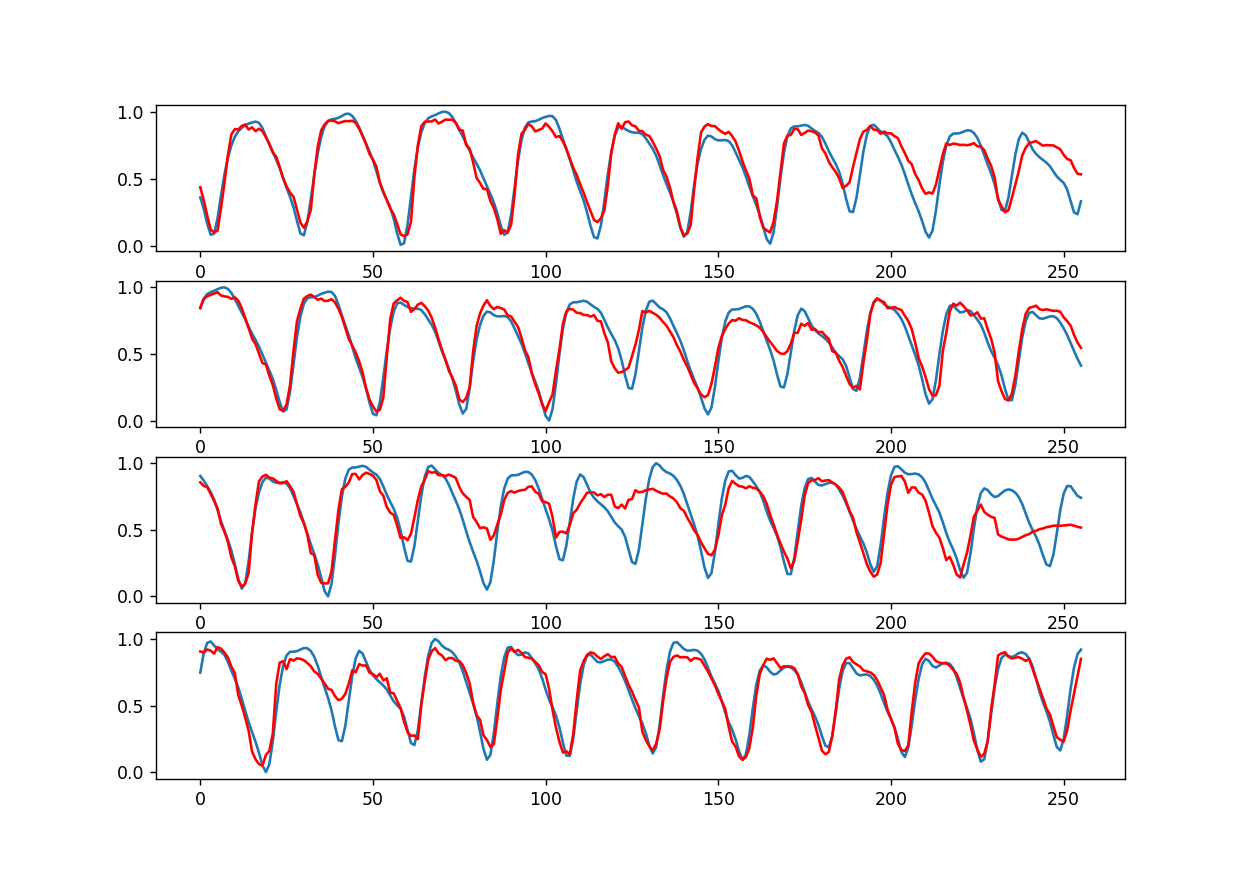

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


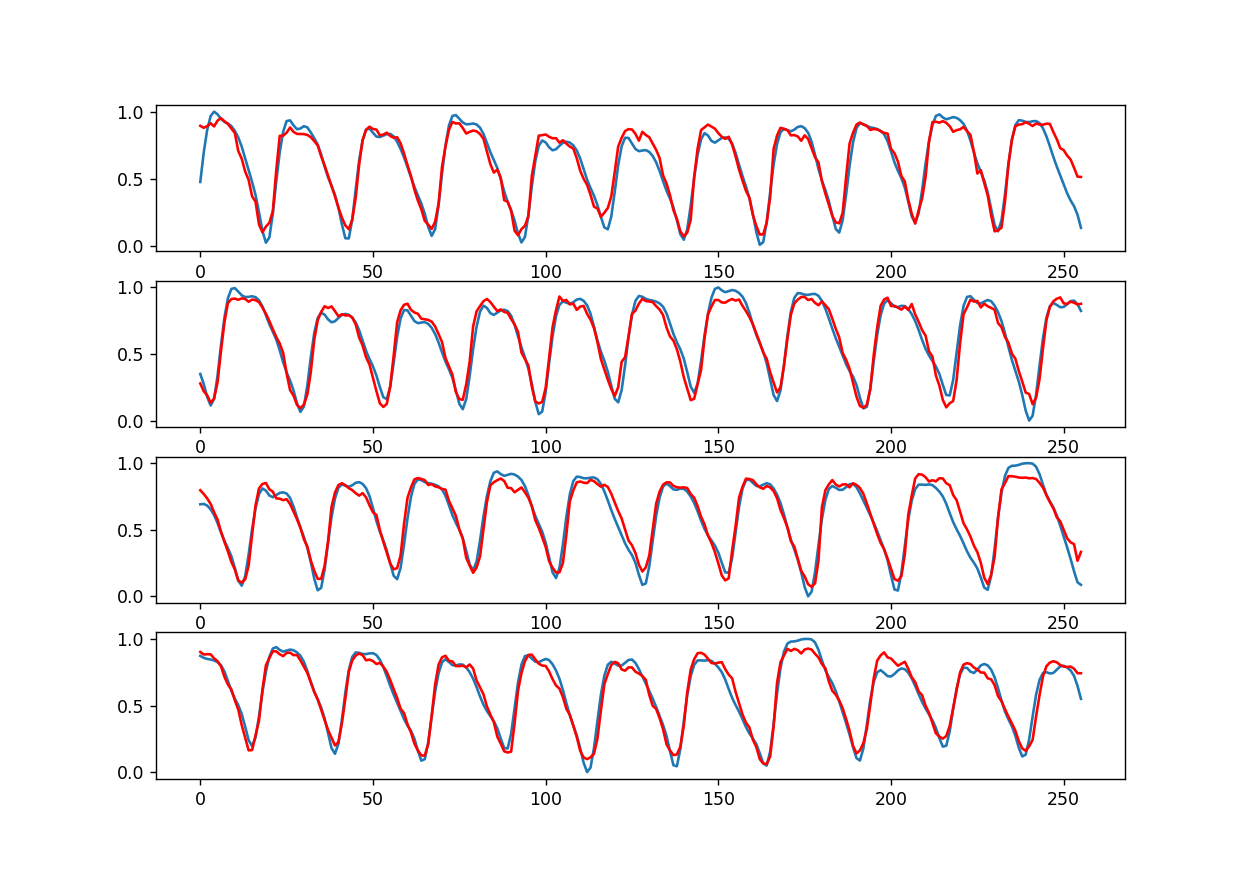

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


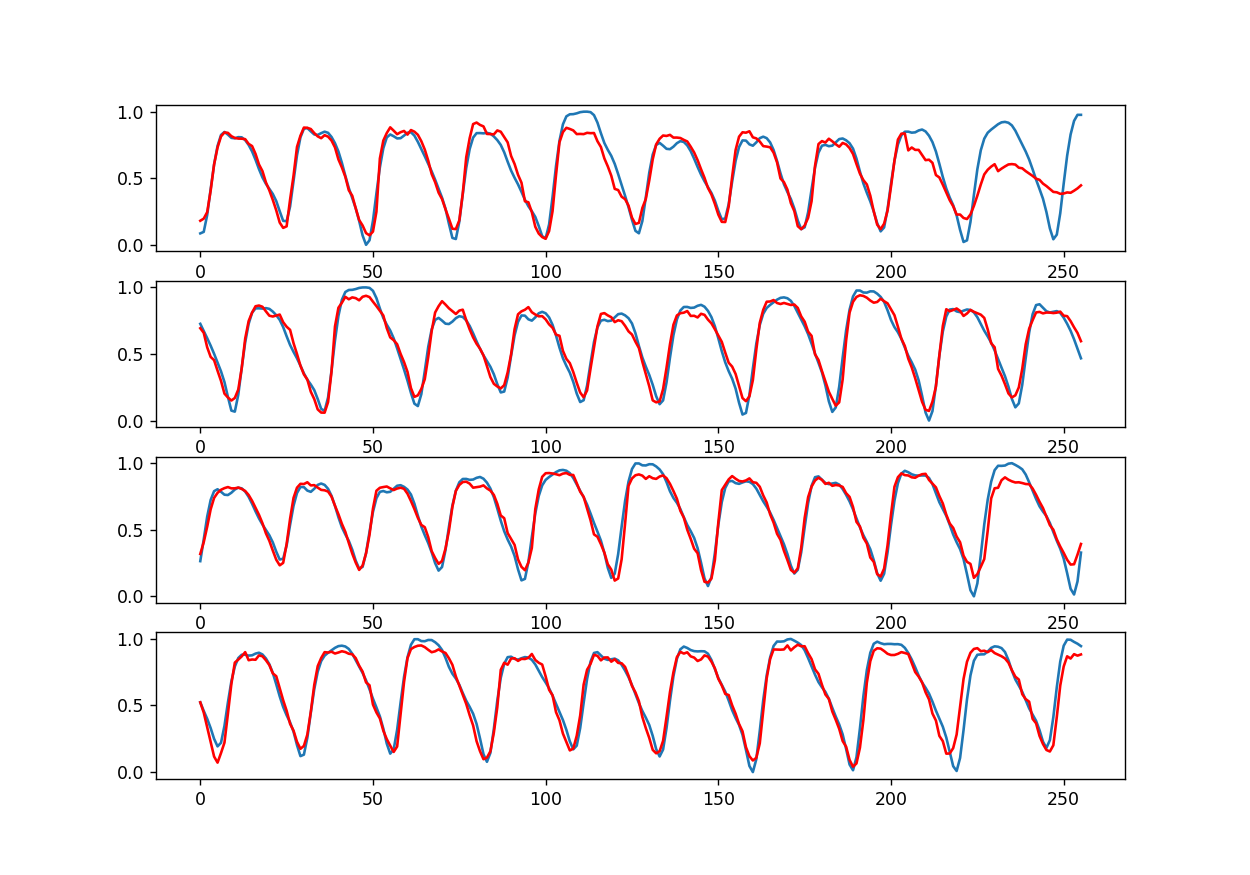

In [64]:
for i in range(1,100,4):
    
    fig,ax = plt.subplots(4,1,figsize=(10,7))
    ax[0].plot(test_y[i])
    ax[0].plot(test_y_pred[i],'r')
    ax[1].plot(test_y[i+1])
    ax[1].plot(test_y_pred[i+1],'r')
    ax[2].plot(test_y[i+2])
    ax[2].plot(test_y_pred[i+2],'r')
    ax[3].plot(test_y[i+3])
    ax[3].plot(test_y_pred[i+3],'r')
    
    plt.show()